# ZCU216 Qick QCoDeS example

This notebook demonstrates the current usage of the ZCU216 qick-qcodes test suite. Currently, as is seen in this demo, multidimensional sweeping is possible for pulse frequency, phase, gain, and length. Only the pulse frequency sweeping is done on software, due to the limitations of the current firmware, and this might lead to noticeable overhead when sweeping frequency. Other sweep variables are looped over in hardware, and you can combine these sweeps in the multidimensional sweep. No other protocols, such as those specifically designed for characterizing qubits are implemented yet. 

## 1. Introduction to Qick program config

To help begin using this program, I will go over the typical Qick program config parameters, which configure the specific Qick measurement. Each of these configuration variables are individual gettable and settable QCoDeS parameters of the ZCU216MetaInstrument. Currently, they have "reasonable" preset values in the code, but there is a method in the ZCU216Station to easily configure your own default parameter values. A typical qick program configuration dictionary (and the current ZCU216Station) has the following parameters:

adc_trig_offset :	(us)         ---- The delay after sending the pulse and beginning the readout 

nqz             :	1 or 2       ---- Nyquist zone, see the example for the difference between these

pulse_freq      :	(MHz)        ---- Frequency of the sent pulse

pulse_gain      :	(DAC units)  ---- Gain of the sent pulse, in DAC units

pulse_length    :	(us)         ---- Length of the sent pulse

pulse_phase     :	(deg)        ---- Phase of the pulse

qubit_ch        :	Integers 0-6 ---- Channel of the generator sending the pulse (at the time of writing, the physical connection on our board is configured from generator channel 6 to readout channel 0)

res_ch          :	0 or 1       ---- Readout channel number

readout_length  :	(us)         ---- Lenght of the readout

relax_delay     :	(us)         ---- Relax time between pulses

reps            :	Integers     ---- Amount of repetitions for each pulse

soft_avgs       :	Integers     ---- Not entirely sure, documentations say "number of times to rerun the                                               program, averaging results in software (aka "rounds")", but this does
                                      not seem different to reps in simple single IQ-value measurements. This
                                      may have usage only in the timetrace programs.

### A few notes about the configuration variables

The typical structure of a qick program looping over certain variables in hardware is that an outer loop, containing the sending and reading of a pulse is looped over "reps" times. The results from these reps are averaged. Within each "rep", the hardware level sweeps over each variable corresponding to a register are iterated over, and this constitutes a singular repetition. See https://github.com/openquantumhardware/qick/blob/main/qick_demos/07_Sweep_ND_variables.ipynb for the assembly of a typical ND-sweep program. To get a more accurate result, try increasing the "reps" variable, but know that this increases the time it takes for the program to finish.

If your program gives untypical values, you might need to play around with adc_trig_offset, readout_length, pulse_lenght, and relax_delay, provided that you have the appropriate Nyquist zone. For example, if your relax_delay is too small, the previous pulse might not have time to end before the sending of another pulse, which has an effect on the result. I have not yet found a perfect receipe for these parameters (and there might not be one), but it is a good start to set readout_lenght a bit larger than the pulse_length, and adc_trig_offset a bit smaller than the pulse_length. 

After you have a good set of these parameters, you can use this program to perform measurements using the ZCU216, while automatically saving your results to a QCoDeS database for easy access. 

## 2. Setting up the system

To use this notebook, and begin writing your own experiments, you first need to connect to the ZCU216. Connect your computer to the board with an ethernet cable, and set a static ip-address in the range 10.0.100.xx. The ZCU currently has 10.0.100.16 as its ip address. After you have turned the board on and connected (you may ensure connection using ping), go to the ip 10.0.100.16 on your browser and type the password for a jupyter notebook environment to appear. (You may connect to the machine via SSH, but we have noticed that the system priviledges of the notebook are required for Qick to work properly, and we have not been able to configure this environment for a typical user.) 

This file can currently be found in the location ~/transferred-files-jonatan/qick-qcodes-testing/ . The required imports are also in this directory. Navigate here on the board to find this example. 

## 3. Usage demonstration

Here is a few examples of an actual measurement using the current version of the software, and a demonstration of the basic usage of the ZCU216Station.

### Initialization

In [1]:
from metainstrument import ZCU216Station, ZCU216MetaInstrument
from protocols import NDSweepProtocol

import qcodes as qc
from qcodes.instrument import Instrument, ManualParameter
from qcodes.station import Station
import qick
print("Qick version:", qick.__version__)

import numpy as np
import matplotlib.pyplot as plt

Qick version: 0.2.211


Firstly, we locate a database in which we will save the measurement results, and then we create a QCoDeS station.

In [2]:
#Initializing the station and the database
qc.initialise_or_create_database_at("./zcu_test_data.db")
station = ZCU216Station()

The station is the highest level of abstraction for the whole system, it contains the configuration of a measurement, and the metainstrument containing the specific configuration variables of the qick program. We can see the current default configuration variables in the following way:

In [3]:
station.zcu.print_readable_snapshot()

zcu:
	parameter      value
--------------------------------------------------------------------------------
IDN             :	{'vendor': None, 'model': 'zcu', 'serial': None, 'firmware'...
adc_trig_offset :	1 (us)
nqz             :	1 
pulse_freq      :	500 (MHz)
pulse_gain      :	10000 (DAC units)
pulse_length    :	10 (us)
pulse_phase     :	0 (deg)
qubit_ch        :	6 
readout_length  :	12 (us)
relax_delay     :	0.1 (us)
reps            :	100 
res_ch          :	0 
soft_avgs       :	1 


In the case that these defaults are not suited for your use, you can give the station a dictionary which will overwrite the hardcoded defaults:

In [4]:
#Configuring your own defaults
my_own_defaults = {"pulse_gain" : 5000, "pulse_length" : 1, "reps" : 10, "adc_trig_offset" : 0.5, "readout_length" : 1 }
station.set_defaults(my_own_defaults)
station.zcu.print_readable_snapshot()

zcu:
	parameter      value
--------------------------------------------------------------------------------
IDN             :	{'vendor': None, 'model': 'zcu', 'serial': None, 'firmware'...
adc_trig_offset :	0.5 (us)
nqz             :	1 
pulse_freq      :	500 (MHz)
pulse_gain      :	5000 (DAC units)
pulse_length    :	1 (us)
pulse_phase     :	0 (deg)
qubit_ch        :	6 
readout_length  :	1 (us)
relax_delay     :	0.1 (us)
reps            :	10 
res_ch          :	0 
soft_avgs       :	1 


In [5]:
#You can also return to the original defaults:
station.set_original_defaults()

### Frequency sweep measurement

The syntax for running a measurement is simple, and the results are stored automatically into the database. The measurements return a run_id, with which one can find the measurement in the database corresponding to the unique run_id.

In [8]:
#A simple frequency sweep, demonstrating the difference between the nyquist zones

#You can individually set parameter values
station.zcu.pulse_gain(20000)

#Setting the nyquist zone to 1
station.zcu.nqz(1)

#Here is an example of an IQ measurement. By using the protocol NDSweepProtocol, and giving the sweep parameters within a dictionary
#the keys in the dictionary are sweepable zcu metainstrument parameters, and the lists contain the start value,
#end value, and the step amount of the sweep.
run_id_nqz1 = station.measure_iq(params_and_values = {station.zcu.pulse_freq: [100,8000,2000]}, protocol = NDSweepProtocol())

#Again for the second nyquist zone
station.zcu.nqz(2)
run_id_nqz2 = station.measure_iq(params_and_values = {station.zcu.pulse_freq: [100,8000,2000]}, protocol = NDSweepProtocol())


Starting experimental run with id: 485. 
Starting experimental run with id: 486. 


We can then access the database, and inspect our results.

Text(0, 0.5, 'Amplitude')

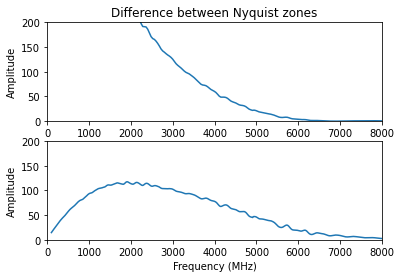

In [9]:
#Plotting the results
ds1 = qc.load_by_id(run_id_nqz1).to_xarray_dataset()
ds2 = qc.load_by_id(run_id_nqz2).to_xarray_dataset()


plt.subplot(2, 1, 1)
plt.plot(ds1["pulse_freq"], abs(ds1["avg_q"] + 1j*ds1["avg_i"]))
plt.ylim(0,200)
plt.xlim(0,8000)
plt.title('Difference between Nyquist zones')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(ds2["pulse_freq"], abs(ds2["avg_q"] + 1j*ds2["avg_i"]))
plt.ylim(0,200)
plt.xlim(0,8000)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')

### Two dimensional sweep measurement, pulse gain and phase.

Multidimensional sweeping is simple, you just add another element into the params_and_values dictionary.

In [20]:
#Since we have implemented multidimensional sweeping, we may do a sweep of phase over gain 
station.zcu.reps(5)
phase_over_gain_id = station.measure_iq(params_and_values = {
    station.zcu.pulse_phase: [0,360,200],
    station.zcu.pulse_gain: [1000, 10000, 200]},
    protocol = NDSweepProtocol())

ds_gain_phase = qc.load_by_id(phase_over_gain_id).to_xarray_dataset()

Starting experimental run with id: 488. 


Text(0.5, 0, 'Phase (degrees)')

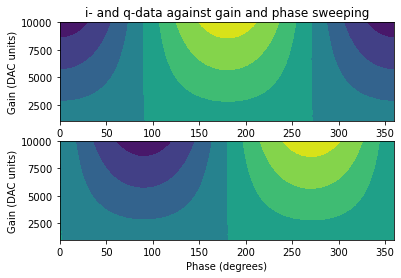

In [21]:
#We may then separately plot the i and q data against gain and phase

plt.subplot(2, 1, 1)
plt.contourf(ds_gain_phase["pulse_gain"], ds_gain_phase["pulse_phase"] , ds_gain_phase["avg_q"])
plt.title('i- and q-data against gain and phase sweeping')
plt.ylabel('Gain (DAC units)')
plt.xlabel('Phase (degrees)')


plt.subplot(2, 1, 2)
plt.contourf(ds_gain_phase["pulse_gain"], ds_gain_phase["pulse_phase"] , ds_gain_phase["avg_i"])
plt.ylabel('Gain (DAC units)')
plt.xlabel('Phase (degrees)')

Text(0.5, 0, 'Phase (degrees)')

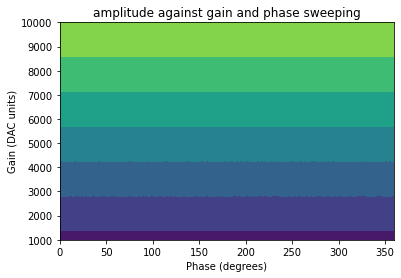

In [22]:
#The amplitude from the previous sweep
plt.contourf(ds_gain_phase["pulse_gain"], ds_gain_phase["pulse_phase"], abs(ds_gain_phase["avg_q"]+1j*ds_gain_phase["avg_i"]))
plt.title('amplitude against gain and phase sweeping')
plt.ylabel('Gain (DAC units)')
plt.xlabel('Phase (degrees)')

### Band-pass filter

This example is here just for my own curiosity

In [14]:
#Frequency sweep using a bandpass filter 1.35-1.45 GHz

station.zcu.pulse_gain(20000)
station.zcu.nqz(1)
bandpass_run_id = station.measure_iq(params_and_values = {station.zcu.pulse_freq: [500,2500,1000]}, protocol = NDSweepProtocol())

Starting experimental run with id: 398. 


In [15]:
no_bandpass_run_id = station.measure_iq(params_and_values = {station.zcu.pulse_freq: [500,2500,1000]}, protocol = NDSweepProtocol())

Starting experimental run with id: 399. 


Text(0, 0.5, 'Amplitude')

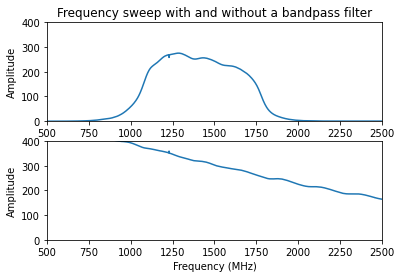

In [18]:
#Plotting the results
no_bp_ds = qc.load_by_id(no_bandpass_run_id).to_xarray_dataset()
bp_ds = qc.load_by_id(bandpass_run_id).to_xarray_dataset()

plt.subplot(2, 1, 1)
plt.plot(bp_ds["pulse_freq"], abs(bp_ds["avg_q"] + 1j*bp_ds["avg_i"]))
plt.ylim(0,400)
plt.xlim(500,2500)
plt.title('Frequency sweep with and without a bandpass filter')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(no_bp_ds["pulse_freq"], abs(no_bp_ds["avg_q"] + 1j*no_bp_ds["avg_i"]))
plt.ylim(0,400)
plt.xlim(500,2500)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')